# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler
import shutil
import tensorflow as tf
from catboost import CatBoostClassifier

# Desing ML Model

In [ ]:
# Reading data with original 69 Features
train_data = pd.read_csv("Data/train_data.csv", compression = "bz2")
test_data = pd.read_csv("Data/test_data.csv", compression = "bz2")

# Reading questions-based features
train_vectors = pd.read_pickle("train_vectors.pkl", compression = "bz2")
test_vectors = pd.read_pickle("test_vectors.pkl", compression = "bz2")

In [ ]:
print("Number of rows in train data =", train_data.shape[0])
print("Number of columns in train data =", train_data.shape[1])

Number of rows in train data = 323443
Number of columns in train data = 69


In [ ]:
print("Number of rows in test data =", test_data.shape[0])
print("Number of columns in test data =", test_data.shape[1])

Number of rows in test data = 80868
Number of columns in test data = 69


In [ ]:
print("Number of rows in train vectors =", train_vectors.shape[0])
print("Number of columns in train vectors =", train_vectors.shape[1])

Number of rows in train vectors = 323443
Number of columns in train vectors = 300


In [ ]:
print("Number of rows in train vectors =", test_vectors.shape[0])
print("Number of columns in train vectors =", test_vectors.shape[1])

Number of rows in train vectors = 80868
Number of columns in train vectors = 300


Now we will choose the columns we need out of our original features space, it seem to say that the features i designed using log transformation caused some problem when applying log on zero or near-zero values, and that has impacted a wide range on data, so i choose to discard those feautres and drop them out of features space.

If we choose to let them, we have to modify log transformation we have applied on the data so we don't have to do log on zero values as in our first processing, and there is various way to fix this issues.

In [ ]:
cols = ['question1_len', 'question2_len', 'question1_freq',
       'question2_freq', 'len_diff', 'question1_n_words', 'question2_n_words',
       'words_diff', 'words_common', 'words_share', 'frequency_sum',
       'frequency_diff', 'words_share_square',
       'words_common_square', 'cw_to_min_c', 'cw_to_max_c', 'cs_to_min_c',
       'cs_to_max_c', 'ct_to_min_c', 'ct_to_max_c', 'last_equal',
       'first_equal', 'tokens_diff', 'sequence_matcher',
       'levenshtein_distance', 'token_set_ratio', 'token_sort_ratio',
       'fuzzy_ratio', 'fuzzy_partial_ratio', 'lognest_substring_ratio',
       'ecludian_distance', 'ct_to_max_c_root', 'ct_to_max_c_sin',
       'ct_to_min_c_cos', 'ct_to_min_c_root','ct_to_min_c_sin', 'ct_to_min_c_square', 
        'cw_to_min_c_root','cw_to_min_c_cos', 'cw_to_max_c_root', 'cw_to_max_c_sin',
       'levenshtein_distance_root','levenshtein_distance_sin','lognest_substring_ratio_sin',
       'fuzzy_ratio_root', 'fuzzy_partial_ratio_root', 'token_sort_ratio_root',
       'token_sort_ratio_square', 'token_set_ratio_root',
       'sequence_matcher_cos', 'sequence_matcher_root',
       'sequence_matcher_sin', 'sequence_matcher_square',
       'sequence_matcher_cube', "is_duplicate"]
      
train_data = train_data[cols]
test_data = test_data[cols]

In [ ]:
y_test = test_data[["is_duplicate"]]
y_train = train_data[["is_duplicate"]]

train_data.drop(["is_duplicate"], axis = 1, inplace = True)
test_data.drop(["is_duplicate"], axis = 1, inplace = True)

x_train = train_data
x_test = test_data

In [ ]:
print("Number of rows in x_train =", x_train.shape[0])
print("Number of columns in x_train =", x_train.shape[1])

Number of rows in x_train = 323443
Number of columns in x_train = 54


In [ ]:
print("Number of rows in x_test =", x_test.shape[0])
print("Number of columns in x_test =", x_test.shape[1])

Number of rows in x_test = 80868
Number of columns in x_test = 54


In [ ]:
# Mergin original features with questions vectors

x_train = np.hstack((x_train ,train_vectors))
x_test = np.hstack((x_test,  test_vectors))

Now after we have finished calling, mergin aka prepering our data, we have to prepare some validation data to use it in our model so to monitor the best performance, and as we did not split this data at first, we can't take it now for train data so we have to split it from test data as follow.

In [ ]:
x_valid = x_test[-30000:]
y_valid = y_test[-30000:]

x_test = x_test[:-30000]
y_test = y_test[:-30000]

In [ ]:
y_train = y_train.values
y_valid = y_valid.values
y_test = y_test.values


y_train = y_train.ravel()
y_valid = y_valid.ravel()
y_test = y_test.ravel()

Remember our main task is to increase **Precision**, and of course if we do that we don't the **Recall** to drop down, but here let's be more specific, our main concern is to reduce **False Positive** ratio aka **FP**, because **False Positive** means that we have predicted two questions to be duplicate while they are not and that's as i mentioned earlier is really dangerous because in this case whis would yield not related answers to some questions and that is really bad, while if two questions are indeed duplicate and our model predict them to be not duplicate this is bad but not as bad as the previous case but of course we don't want that as well, because in this case our model will not work properly so not predicting anything useful.

Now, we shall try ML alogorithm specifically GBDT using CatBoost as it turened to be the most suitable one for this problem.

In [ ]:
clf = CatBoostClassifier(task_type = "GPU", bootstrap_type = "Bernoulli", n_estimators = 54000, depth = 9, fold_permutation_block = 250, learning_rate = 0.007 , rsm = 1. , subsample = 0.05, reg_lambda = 1500)

In [ ]:
#: 'Poisson', 'Bayesian', 'Bernoulli', 'MVS', 'No'. 
clf.fit(x_train, y_train,  eval_set = (x_valid, y_valid), use_best_model = True, verbose = 2)

53982:	learn: 0.2407718	test: 0.3581872	best: 0.3581872 (53982)	total: 46m 4s	remaining: 871ms
53984:	learn: 0.2407689	test: 0.3581857	best: 0.3581857 (53983)	total: 46m 4s	remaining: 768ms
53986:	learn: 0.2407648	test: 0.3581841	best: 0.3581841 (53986)	total: 46m 5s	remaining: 666ms
53988:	learn: 0.2407623	test: 0.3581832	best: 0.3581832 (53988)	total: 46m 5s	remaining: 563ms
53990:	learn: 0.2407583	test: 0.3581825	best: 0.3581824 (53989)	total: 46m 5s	remaining: 461ms
53992:	learn: 0.2407542	test: 0.3581815	best: 0.3581815 (53992)	total: 46m 5s	remaining: 359ms
53994:	learn: 0.2407513	test: 0.3581803	best: 0.3581803 (53994)	total: 46m 5s	remaining: 256ms
53996:	learn: 0.2407499	test: 0.3581803	best: 0.3581803 (53994)	total: 46m 5s	remaining: 154ms
53998:	learn: 0.2407459	test: 0.3581796	best: 0.3581796 (53998)	total: 46m 5s	remaining: 51.2ms
53999:	learn: 0.2407452	test: 0.3581796	best: 0.3581796 (53998)	total: 46m 5s	remaining: 0us
bestTest = 0.3581795573
bestIteration = 53998
Shrin

In [ ]:
y_train_prob = clf.predict_proba(x_train)
y_valid_prob = clf.predict_proba(x_valid)

In [ ]:
y_train_pred = clf.predict(x_train)
y_valid_pred = clf.predict(x_valid)

In [ ]:
print("Log Loss for train data =", log_loss(y_train, y_train_prob))
print("*********************************************")
print("Log Loss for valid data =", log_loss(y_valid, y_valid_prob))

Log Loss for train data = 0.2407459460883208
*********************************************
Log Loss for valid data = 0.3581795077103383


In [ ]:
print("Precision Score for train data =", precision_score(y_train, y_train_pred) * 100)
print("*********************************************")
print("Precision Score for valid data =", precision_score(y_valid, y_valid_pred) * 100)

Precision Score for train data = 89.57526702269692
*********************************************
Precision Score for valid data = 76.89224459358688


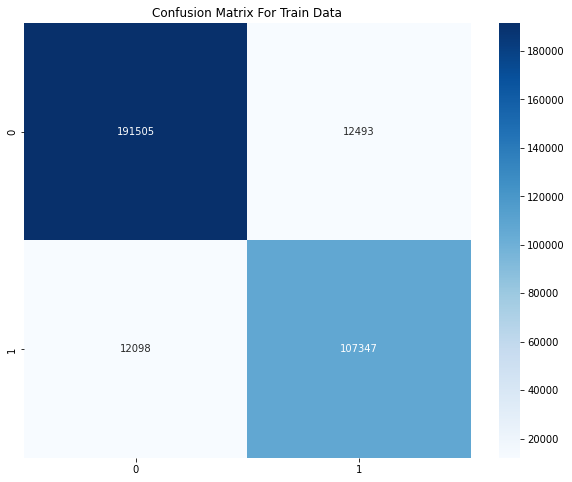

In [ ]:
plt.figure(figsize = (10, 8))
sns.heatmap(confusion_matrix(y_train , y_train_pred), annot = True, fmt = "d", cmap = "Blues")
plt.title("Confusion Matrix For Train Data")
plt.show()

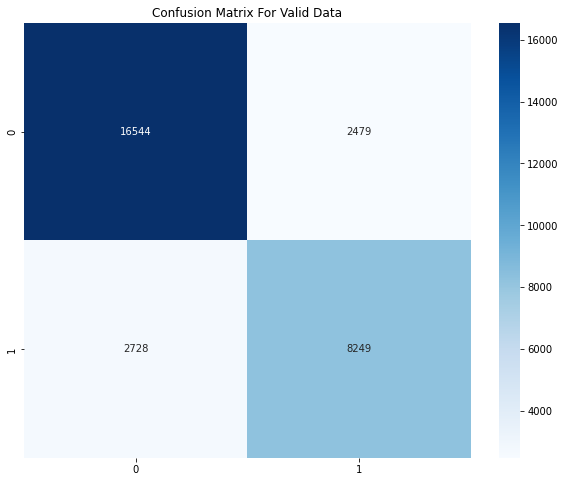

In [ ]:
plt.figure(figsize = (10, 8))
sns.heatmap(confusion_matrix(y_valid , y_valid_pred), annot = True, fmt = "d", cmap = "Blues")
plt.title("Confusion Matrix For Valid Data")
plt.show()

In [ ]:
y_train_pred1 = (y_train_prob[:, 1] >= 0.6)
y_valid_pred1 = (y_valid_prob[:, 1] >= 0.6)

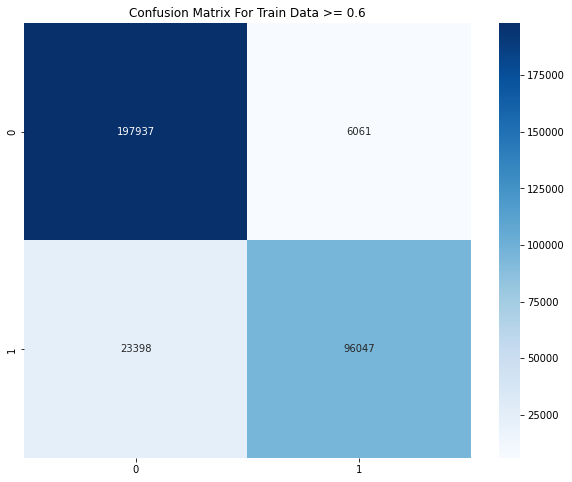

In [ ]:
plt.figure(figsize = (10, 8))
sns.heatmap(confusion_matrix(y_train , y_train_pred1), annot = True, fmt = "d", cmap = "Blues")
plt.title("Confusion Matrix For Train Data >= 0.6")
plt.show()

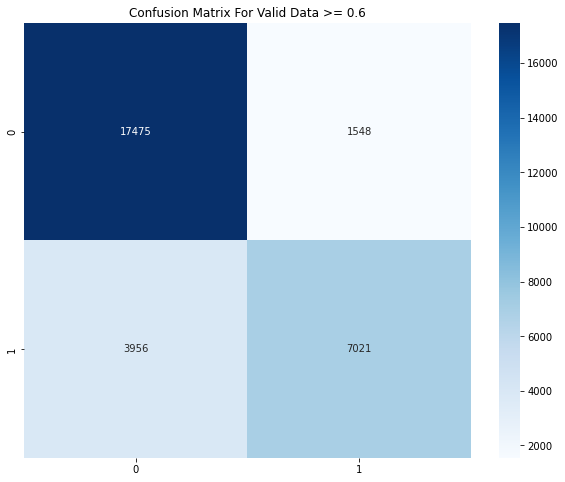

In [ ]:
plt.figure(figsize = (10, 8))
sns.heatmap(confusion_matrix(y_valid , y_valid_pred1), annot = True, fmt = "d", cmap = "Blues")
plt.title("Confusion Matrix For Valid Data >= 0.6")
plt.show()

# Evaluating ML Model on Test Data

Now after we have done building our two models, time to evaluate our model on test data, and this step happend only once at final stage, we can't test model performance on test data more than one time, otherwise this will not be reflect the actual result.

In [ ]:
y_test_prob = clf.predict_proba(x_test)

y_test_pred = clf.predict(x_test)

In [ ]:
print("Log Loss for test data =", log_loss(y_test, y_test_prob))

Log Loss for test data = 0.3593969949461629


In [ ]:
print("Precision Score for test data =", precision_score(y_test, y_test_pred) * 100)

Precision Score for test data = 77.20547945205479


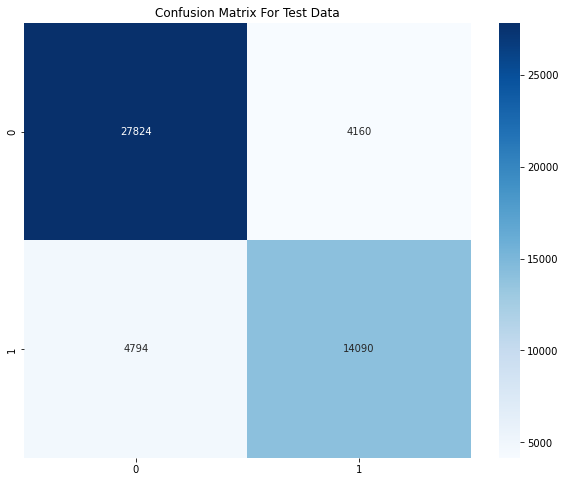

In [ ]:
plt.figure(figsize = (10, 8))
sns.heatmap(confusion_matrix(y_test , y_test_pred), annot = True, fmt = "d", cmap = "Blues")
plt.title("Confusion Matrix For Test Data")
plt.show()

In [ ]:
y_test_pred1 = (y_test_prob[:, 1] >= 0.6)

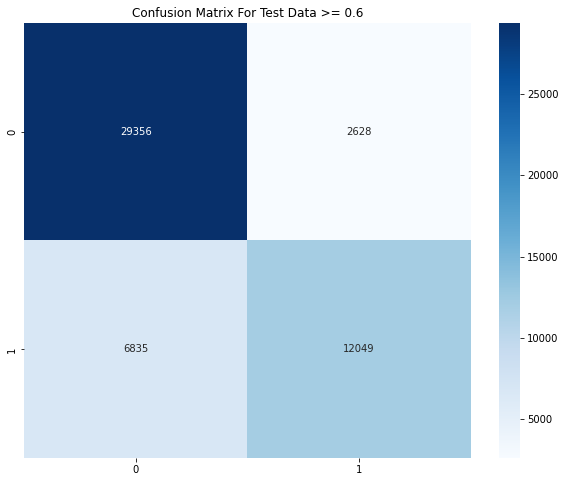

In [ ]:
plt.figure(figsize = (10, 8))
sns.heatmap(confusion_matrix(y_test , y_test_pred1), annot = True, fmt = "d", cmap = "Blues")
plt.title("Confusion Matrix For Test Data >= 0.6")
plt.show()